# 1: init:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"]=[12., 8.]

import pandas as pd

from xls2dict import xls2dict
from fivepoint import derive

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

from math import factorial#, log10
from types import MethodType
# ----------------------------------------------------------------
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range]
                      for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

from math import isnan
def cregion(df,col):
    for _j in range(4,df.shape[0]):
        if isnan(df.iloc[_j,col]): return (df.iloc[4:_j,col].values,df.iloc[4:_j,col+1].values)
        else: _j+=1

class xlsdata(xls2dict):
    def __init__(self, *source):
        xls2dict.__init__(self, *source)
        self.sheets = [[_,[]] for _ in sorted(self.data, key=lambda x: int(x.split(u'°C')[0]))]
        _j = 0
        for _s in self.sheets:
            yx = self.data[_s[0]]
            self.sheets[_j][1] = ["%s:%d" % (yx.iloc[1,_],_) for _ in range(1,yx.shape[1],3)]
            _j+=1
    def evaluate(self,sheet,nreg):
        yx = self.data[sheet]
        cr = cregion(yx, nreg)
        dydx = np.array([_ for _ in derive(cr[0], cr[1])])/100.
        dpos = dydx>0.
        self.dY = dydx[dpos]
        self.x = (cr[0]/np.abs(cr[0]).max())[dpos]
        self.ds = savitzky_golay(self.dY, 2*int(0.02*len(dydx))+1, 1,0,1)
        dsmin = self.ds.argmin()
        self.xmin = self.x[dsmin]
        self.ymin = self.ds[dsmin]
        return self.ymin
    
    def makeplot(self,sheet,plot):
        oneplot = plot.split(':')
        self.evaluate(sheet,int(oneplot[1])-1)
        plt.title("%s [%s:%s]\nmin = %s(%s)" % (sheet,oneplot[0],oneplot[1], xls2.ymin,xls2.xmin))
        plt.semilogy(self.x, self.dY, ':', self.x,self.ds,'-', self.xmin,self.ymin,'ok');
        plt.annotate('', xy=(self.xmin, self.ymin), xytext=(self.xmin, self.ymin*0.7));
        plt.show();

# 2: UPLOAD workbook:

In [ ]:
xls2 = xlsdata()

# 3: READ workbook from local file:

In [3]:
xls2 = xlsdata('Creep.xls')

File 'Creep.xls' readed successfully!


# 4: calculation all derivative:

In [7]:
vitesse_all_T = {}
for _i in xls2.sheets:
    vitesse_all_T[_i[0]] = []
    vitesse_all_T[_i[0]].append(map(lambda x:float(x.split(':')[0]),_i[1]))
    nreg = map(lambda x:int(x.split(':')[1])-1,_i[1])
    vitesse_all_T[_i[0]].append(map(lambda x:xls2.evaluate(_i[0],x),nreg))

# 5: plotting all derivative:

[500 °C] 0.000628x + -0.218123
[600°C] 0.000540x + -0.074448
[700°C] 0.001596x + -0.052138
[800°C] 0.004178x + -0.100154
[900°C] 0.004377x + -0.060945
[1000°C] 0.012057x + -0.138976
[1100°C] 0.026310x + -0.139436
[1200°C] 0.048902x + -0.150428
[1300°C] 0.040179x + -0.041170


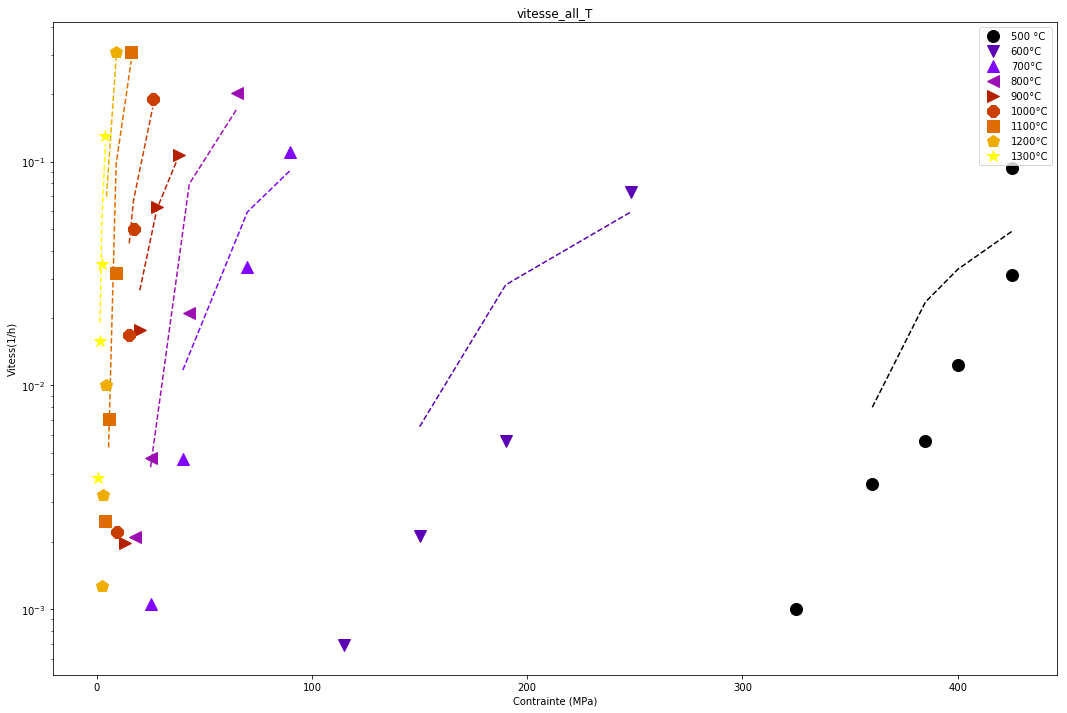

In [8]:
%matplotlib inline
from scipy.optimize import curve_fit
#inline notebook
plt.rcParams["figure.figsize"]=[18., 12.]
#markers = [(2+i/2, 1+i%2, 0) for i in range(16)]
markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(xls2.sheets))]

i=0
for _ in xls2.sheets:
    _k = _[0]
    x,y = map(lambda q:np.array(q), vitesse_all_T[_k])
    
    z = np.polyfit(x, y, 1)
    print "[%s] %.6fx + %.6f" % (_k, z[0],z[1])
    p = np.poly1d(z)
    plt.semilogy(x, p(x),'--',color=colors[i])
    plt.semilogy(x, y,  color=colors[i], label= _k, 
                 marker = markers[i],ms=12,linestyle='None')
    i+=1

plt.ylabel('Vitess(1/h)')
plt.xlabel('Contrainte (MPa)')
plt.title('vitesse_all_T')
plt.legend(loc='upper right');

# 6: printing all derivative:

In [9]:
for _ in xls2.sheets:
    _k = _[0]
    print "'%s':\n\t" % _k ,
    _len = len(vitesse_all_T[_k][0])
    for _j in range(_len):
        print vitesse_all_T[_k][0][_j],',',
    print '\n\t',
    for _j in range(_len):
        print vitesse_all_T[_k][1][_j],',',
    print    

'500 °C':
	425.0 , 425.0 , 400.0 , 385.0 , 360.0 , 325.0 , 
	0.0311166666667 , 0.09395 , 0.0123411643138 , 0.00565142310717 , 0.00360206464482 , 0.000996132070739 ,
'600°C':
	115.0 , 150.0 , 190.0 , 248.0 , 
	0.000688964048603 , 0.00212952524114 , 0.00563622698234 , 0.0732807215333 ,
'700°C':
	25.0 , 40.0 , 70.0 , 90.0 , 
	0.00105519131667 , 0.00467553383718 , 0.0339145220168 , 0.110875266859 ,
'800°C':
	18.0 , 25.0 , 43.0 , 65.0 , 
	0.00209700176367 , 0.0047138047138 , 0.0209777777778 , 0.202495974235 ,
'900°C':
	13.0 , 20.0 , 28.0 , 38.0 , 
	0.00196759259259 , 0.0176037037037 , 0.0627223625602 , 0.107203687005 ,
'1000°C':
	9.5 , 15.1 , 17.1 , 26.0 , 
	0.00220833333333 , 0.0167284586667 , 0.0500912533434 , 0.19133688593 ,
'1100°C':
	4.0 , 5.5 , 9.0 , 16.0 , 
	0.00246259173802 , 0.0070408522091 , 0.0318466600698 , 0.308591101289 ,
'1200°C':
	2.4 , 3.0 , 4.5 , 9.0 , 
	0.00126388888889 , 0.00324126984127 , 0.01 , 0.30803080308 ,
'1300°C':
	0.8 , 1.5 , 2.4 , 4.0 , 
	0.00384035087719 , 0.0

# 7: User interface, choise one sheet from one sheet:

In [ ]:
def plot_make(b):
    dsk = b.description.split('[')
    sh = dsk[0]
    pl = dsk[1][0:-1]
    %matplotlib inline
    plt.rcParams["figure.figsize"]=[13., 9.]
    xls2.makeplot(sh,pl)

def plots_view(x):
    w2.options = w1.value
def plot_select(x):
    _i = map(lambda x:x[1],xls2.sheets).index(w1.value)
    w3.description="%s[%s]" % (xls2.sheets[_i][0],x)

w1 = widgets.Select(options=xls2.sheets)
w2 = widgets.Select(options=w1.value)
_i = map(lambda x:x[1],xls2.sheets).index(w1.value)    
w3 = widgets.Button(description="%s[%s]" % (xls2.sheets[_i][0],w2.value))

w3.on_click(plot_make)
h = widgets.HBox([w1,w2,w3])
i = interactive(plots_view,x=w1)
j = interactive(plot_select, x=w2)
display(h)

# 8: Plotting assistant from cmdline

In [5]:
_i = 0
for _s in xls2.sheets:
    print '\n', "%d:" % _i, `_s[0]`,'\n\t',
    _i+=1; _j = 0
    for _p in _s[1]:
        print "%d:%r" % (_j, _p),
        _j+=1

def mkplot(nsh,npl):
    xls2.makeplot(xls2.sheets[nsh][0],xls2.sheets[nsh][1][npl])


0: u'500 \xb0C' 
	0:'425:1' 1:'425:4' 2:'400:7' 3:'385:10' 4:'360:13' 5:'325:16' 
1: u'600\xb0C' 
	0:'115:1' 1:'150:4' 2:'190:7' 3:'248:10' 
2: u'700\xb0C' 
	0:'25:1' 1:'40:4' 2:'70:7' 3:'90:10' 
3: u'800\xb0C' 
	0:'18:1' 1:'25:4' 2:'43:7' 3:'65:10' 
4: u'900\xb0C' 
	0:'13:1' 1:'20:4' 2:'28:7' 3:'38:10' 
5: u'1000\xb0C' 
	0:'9.5:1' 1:'15.1:4' 2:'17.1:7' 3:'26:10' 
6: u'1100\xb0C' 
	0:'4:1' 1:'5.5:4' 2:'9:7' 3:'16:10' 
7: u'1200\xb0C' 
	0:'2.4:1' 1:'3:4' 2:'4.5:7' 3:'9:10' 
8: u'1300\xb0C' 
	0:'0.8:1' 1:'1.5:4' 2:'2.4:7' 3:'4:10'


### 8.1: mkplot(2,1) === xls2.makeplot(u'700\xb0C','40:4')

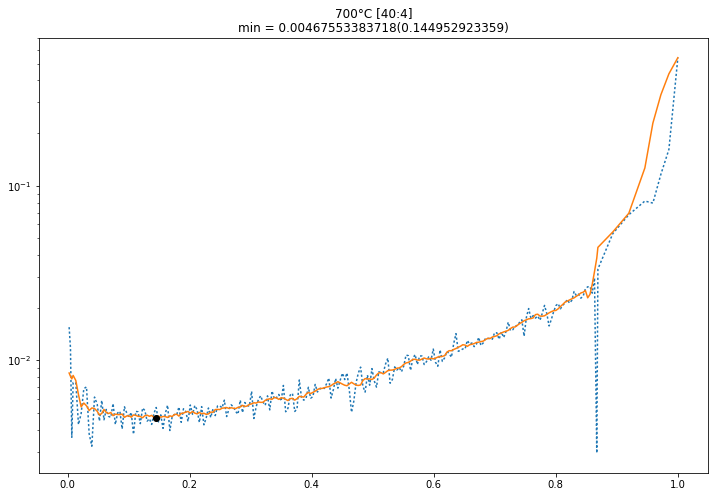

In [6]:
#xls2.makeplot(u'700\xb0C','40:4')
mkplot(2,1)

# show all original plots from workbook:

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"]=[12., 8.]
for _ in xls2.sheets:
    dxy =xls2.data[_[0]]
    plt.title(_[0])
    for _c in _[1]:
        _n = int(_c.split(':')[1])-1
        cr = cregion(dxy,_n)
        plt.plot(cr[0], cr[1],'-', label=_c)
    plt.ylabel('Elongation(%)')
    plt.xlabel('Time(h)')
    plt.legend(loc='lower right')
    plt.show()
;

# make one derivative plot from one sheet via 'plotly':

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode()

dsk = w3.description.split('[')
sh = dsk[0]
pl = dsk[1][0:-1]
oneplot = pl.split(':')
xls2.evaluate(sh,int(oneplot[1])-1)

trace1 = go.Scatter(x=xls2.x, y=xls2.dY, mode = 'markers')
trace2 = go.Scatter(x=xls2.x, y=xls2.ds)
trace3 = go.Scatter(x=[xls2.xmin,], y=[xls2.ymin,], mode = 'markers', name = 'min')

data = [trace1,trace2,trace3]
layout = go.Layout(
    xaxis=dict(
        autorange=True
    ),
    yaxis=dict(
        type='log',
        autorange=True
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [ ]:
vitesse_all_T